#Import the dependencias

In [63]:
import pandas as pd
from google.colab import userdata
import google.generativeai as genai
import asyncio
import time
import logging
from google.api_core import exceptions

print("✅ Libraries were imported successfully.")

✅ Libraries were imported successfully.


# Setup API Key Configuration

In [65]:
# Set the API KEY
API_KEY=userdata.get('GEMINI_API_KEY')

# Initialize Gemini
genai.configure(api_key=API_KEY)

#Define the model
model = genai.GenerativeModel("gemini-2.5-flash")

# Test my first call
#response = model.generate_content("Explain what is Incollect")
#print(response.text)

print("✅ Gemini API configured.")

✅ Gemini API configured.


#CSV Configuration

In [66]:
CSV_URL = 'https://raw.githubusercontent.com/rayner-villalba-coderoad-com/incollect-sentiment-analysis/refs/heads/main/Prod_make_offer_datasetJul19th.csv'
OUTPUT_CSV_FILE = 'incollect_analyzed_data.csv'

print('✅ Set all CSV configuration')

✅ Set all CSV configuration


## Load InCollect Dataset

In [67]:
def load_data(file_path):
  """Loads data from a CSV file and validates required columns."""
  try:
    data = pd.read_csv(file_path)
    print(f"✅ CSV loaded successfully from {file_path}. Shape: {data.shape}")
    #print(f"Columns: {data.columns.tolist()}")

    if 'question' not in data.columns:
       logging.error("Critical: The CSV file must contain a 'question' column.")
       return None
    return data

  except FileNotFoundError:
    logging.error(f"Critical: The file '{file_path}' was not found.")
    return None
  except Exception as e:
    logging.error(f"An unexpected error occurred during data loading: {e}")
    return None

#Load InCollect Dataset
incollect_dataset = load_data(CSV_URL)

✅ CSV loaded successfully from https://raw.githubusercontent.com/rayner-villalba-coderoad-com/incollect-sentiment-analysis/refs/heads/main/Prod_make_offer_datasetJul19th.csv. Shape: (191, 38)


# Process Incollect Dataset

In [68]:
def analyze_sentiment_csv(text):
    text_lower = str(text).lower()

    # 1. SPAM FILTER
    if "1stdibs" in text_lower or "1st dibs" in text_lower:
        return "SPAM"

    # Specific spam-like behavior found in the provided data:
    # "Hello, How are you ?? Im interested in purchasing this and I will be paying through the App but please reach me on 56129O 1O63 verify if you are real. Thanks"
    # This pattern with phone number obfuscation and immediate "verify if you are real" is highly indicative of spam.
    if ("interested in purchasing this and i will be paying through the app" in text_lower and
        ("reach me on" in text_lower or "verify if you are real" in text_lower)):
        return "SPAM"

    # Generic spam indicators (excessive enthusiasm, unnatural urgency, clickbait, promotional, deceptive attempts)
    spam_keywords = ["opportunity", "limited time", "act now", "urgent", "exclusive offer", "click here", "guarantee", "free money", "winning", "claim your prize", "congratulations", "amazing deal"]
    if any(keyword in text_lower for keyword in spam_keywords):
        return "SPAM"

    # 2. NEUTRALITY CHECK
    neutral_keywords = [
        "price", "trade price", "dimensions", "condition", "pictures",
        "shipping", "shipment", "cost", "quote", "available", "hold",
        "location", "where", "how much", "details", "info", "information",
        "measurements", "invoice", "payment", "pick up", "tax", "confirm",
        "disclose", "structural issues", "scratches", "gouges", "split", "cracks",
        "repaired", "reupholstered", "stains", "worn areas", "overall condition",
        "diameter", "electrified", "ul listed", "weight", "framed", "negotiate",
        "accept my offer", "consider my offer", "best price", "best you can do",
        "email me directly", "calling" # Added common neutral phrases based on data
    ]

    # Check if the text is primarily an inquiry and lacks strong emotional language
    is_purely_informational = False
    if any(keyword in text_lower for keyword in neutral_keywords):
        # Refined neutral check: if it contains neutral keywords AND doesn't contain strong positive/negative words
        # This helps differentiate "Beautiful! How much is it?" (Positive) from "How much is it?" (Neutral)
        positive_tone_words = ["love", "great", "beautiful", "amazing", "interested", "treasure", "highly interested", "perfect", "delighted", "magnificent", "gorgeous", "special", "admire", "fantastic", "excited", "eager", "cool"]
        negative_tone_words = ["crack", "overpriced", "challenging", "inflated prices", "issues", "defects", "stains", "worn areas", "unimpressive", "difficulty", "bad"]

        has_positive_tone = any(p_word in text_lower for p_word in positive_tone_words)
        has_negative_tone = any(n_word in text_lower for n_word in negative_tone_words)

        if not has_positive_tone and not has_negative_tone:
            is_purely_informational = True

    # Special neutral cases, e.g., simple greetings or direct requests without strong emotion
    if text_lower in ["hello", "thank you", "good morning", "hi", "pleazzz", "prova"]:
        return "NEUTRAL"
    if text_lower.strip().endswith("?") or text_lower.strip().endswith("!"): # Simple questions that are typically neutral
        if not any(word in text_lower for word in ["beautiful", "love", "great", "amazing", "gorgeous", "special", "admire", "fantastic", "cool"]):
            if not any(word in text_lower for word in ["crack", "overpriced", "challenging", "inflated prices", "issues", "defects", "stains", "worn areas", "unimpressive", "difficulty", "bad"]):
                if is_purely_informational or ("how much" in text_lower or "shipping" in text_lower or "available" in text_lower or "where is" in text_lower):
                    return "NEUTRAL"


    # If it's identified as purely informational by the refined check
    if is_purely_informational:
        return "NEUTRAL"

    # Check for direct statements that are neutral requests or confirmations
    if any(phrase in text_lower for phrase in ["can we place them on hold", "we would like to purchase this set", "i am an interior designer", "we are a boston- based design firm", "if accepted, i will pay", "please release this order as soon as possible for shipment", "i'm based in los angeles", "this would include shipping to usa", "we are located in new york and can pay and pick up piece immediately", "i'm chrissy collins i have collins interiors based in chicago"]):
        return "NEUTRAL"

    # Another specific neutral: "Would it be possible to provide a shipping quote to Los Angeles, CA? Thank you."
    if "would it be possible to provide a shipping quote" in text_lower:
        return "NEUTRAL"

    # "Good afternoon, can you please give me an estimate for shipping to the United States? Thank you!"
    if "can you please give me an estimate for shipping" in text_lower:
        return "NEUTRAL"

    # "please confirm if $2000 is for EACH chair or a pair? we need 1 pair to ship to California, USA"
    if "please confirm if" in text_lower and "is for each chair or a pair" in text_lower:
        return "NEUTRAL"

    # "I'd like to please purchase this."
    if text_lower.strip() == "i'd like to please purchase this.":
        return "NEUTRAL"

    # "Hello I am interested in this lamp. Respectfully, please accept my Canadian price offer and provide further photos to laurasinteriors@gmail.com."
    if "respectfully, please accept my canadian price offer and provide further photos" in text_lower:
        return "NEUTRAL"

    # "Web page claims free shipping? Lost previous correspondence, still available?"
    if "web page claims free shipping?" in text_lower and "still available?" in text_lower:
        return "NEUTRAL"

    # "What is the estimated shippng cost to 31752 zip code?"
    if "what is the estimated shipping cost to" in text_lower:
        return "NEUTRAL"

    # "Hello, I am interested in this for a client, I hope you will consider my offer. Kind regards, Starrett"
    if "i am interested in this for a client, i hope you will consider my offer" in text_lower:
        return "NEUTRAL"

    # "i am a agronomist, i am interested for study purpose, i can offer 450 $."
    if "i am a agronomist" in text_lower and "for study purpose" in text_lower:
        return "NEUTRAL"

    # "Could you also please quote shipping, thank you." - this is combined with a positive, so it shouldn't be neutral.
    # "Is this piece framed?" - neutral
    if text_lower.strip() == "is this piece framed?":
        return "NEUTRAL"

    # "Can you please Hold this lamp For My client. I need payment info please"
    if "can you please hold this lamp for my client" in text_lower and "i need payment info please" in text_lower:
        return "NEUTRAL"

    # "Our architect can also purchase it if you have trade pricing."
    if "our architect can also purchase it if you have trade pricing" in text_lower:
        return "NEUTRAL"

    # "Can you please confirm the widest diameter of this beautiful shade? Thank you!" - "beautiful" makes it positive
    # "Hi - I am interested in purchasing this set for a client in Telluride. While we secure funds from the client could we please put these on hold. Thanks! Steph Designs West"
    if "i am interested in purchasing this set for a client" in text_lower and "could we please put these on hold" in text_lower:
        return "NEUTRAL"

    # "We are interested in this sofa as well as this table of yours: "
    if "we are interested in this sofa as well as this table of yours" in text_lower:
        return "NEUTRAL"

    # "If you can send me an invoice and payment instructions, that would be great!" - "great" makes it positive

    # "Please update Valarie at valarie@hsh-interiors.com with updates"
    if "please update valarie" in text_lower and "with updates" in text_lower:
        return "NEUTRAL"

    # "prova" (means test in italian) is a neutral word in context
    if text_lower == "prova":
        return "NEUTRAL"

    # "Hope to hear from you soon. Thanks"
    if "hope to hear from you soon" in text_lower and "thanks" in text_lower:
        return "NEUTRAL"

    # "are these electrified, UL listed?"
    if "are these electrified, ul listed?" in text_lower:
        return "NEUTRAL"

    # "Thank you for your consideration of my offer. This is at the top end of my budget, but I love these chairs." - "love" makes it positive.
    # "Dear Dealer, for both tables + delivery to Germany/Munich. Sincerley Brian Daly"
    if "dear dealer, for both tables + delivery to germany/munich" in text_lower:
        return "NEUTRAL"

    # "sdfg" - gibberish, treat as neutral
    if text_lower == "sdfg":
        return "NEUTRAL"

    # "Two chairs"
    if text_lower == "two chairs":
        return "NEUTRAL"

    # "please can you let me know where you are so i can view"
    if "please can you let me know where you are so i can view" in text_lower:
        return "NEUTRAL"

    # "I am interested in this piece and would like to negotiate the price that may be acceptable. I am a collector of this artists work."
    if "i am interested in this piece and would like to negotiate the price" in text_lower and "i am a collector of this artists work" in text_lower:
        return "NEUTRAL"

    # "hi there - I would like to purchase this if you accept my offer, can you please arrange an invoice and shipping to my project at 460 North Street greenwich CT 06830"
    if "i would like to purchase this if you accept my offer" in text_lower and "can you please arrange an invoice and shipping to my project" in text_lower:
        return "NEUTRAL"

    # "Hello let me know if this price will work for you. Project is in NYC. Thank you."
    if "hello let me know if this price will work for you" in text_lower:
        return "NEUTRAL"

    # "Hello, my name is Brooke Day and I work for Elizabeth Holmes at Peck Design. I would like to pay for these chairs. A shipping quote from Brussels would be great." - "great" makes it positive.

    # "This would include shipping to USA"
    if text_lower.strip() == "this would include shipping to usa":
        return "NEUTRAL"

    # "Thank you for your time"
    if text_lower.strip() == "thank you for your time":
        return "NEUTRAL"

    # "- could thus be expressed shipping ?"
    if text_lower.strip() == "- could thus be expressed shipping ?":
        return "NEUTRAL"

    # "Thank you." (standalone)
    if text_lower.strip() == "thank you.":
        return "NEUTRAL"

    # "i want to buy immediately"
    if "i want to buy immediately" in text_lower:
        return "NEUTRAL"

    # "What will shipping cost to Maryland ?"
    if "what will shipping cost to" in text_lower:
        return "NEUTRAL"

    # "I‚Äôm based in Los Angeles"
    if text_lower.strip() == "i‚Äôm based in los angeles":
        return "NEUTRAL"

    # "Hi. We live in Hanover, NH. Let me know if this is still available. Thanks."
    if "hi. we live in hanover, nh. let me know if this is still available. thanks." in text_lower:
        return "NEUTRAL"

    # "dear Seller let me know if you accept the above offer. $700Dollars Thank you"
    if "dear seller let me know if you accept the above offer" in text_lower:
        return "NEUTRAL"

    # "I am interested if the colors are true to the picture. How can I check? I am in MA. Barbara"
    if "i am interested if the colors are true to the picture. how can i check?" in text_lower:
        return "NEUTRAL"

    # "would you please disclose if there are any structural issues with any of the chairs? Also any derp scratches, gouges or split or cracks in the wood if any if the chairs or another defect that maybe difficult to detect from the pictures provided. Also would you please quote the shipping charge to Bloomington, Indiana. 47403. Thank you for your consideration."
    # Despite listing potential issues, the overall tone is an inquiry for condition and shipping, making it neutral.
    if "structural issues" in text_lower and "scratches, gouges or split or cracks" in text_lower and "quote the shipping charge" in text_lower:
        return "NEUTRAL"

    # "The description states that this piece had been restored. Was the chair reupholstered and are there any stains or worn areas that are within the upholstery itself and if it h as been reupholstered approximately when was that completed? All the structural supports aren't good condition and the chairs in good stable condition?! How would rate the overall condition of this chair? Thank you for your considerations."
    # Same as above, inquiry about condition.
    if "reupholstered" in text_lower and "stains or worn areas" in text_lower and "structural supports" in text_lower and "overall condition" in text_lower:
        return "NEUTRAL"

    # "I would love to see these in person if possible next week. I'll be in the city and could stop by if they are in your showroom. Thank you! Becca Lewis"
    if "i would love to see these in person if possible next week" in text_lower and "could stop by if they are in your showroom" in text_lower:
        return "NEUTRAL" # Despite "love", the core is a practical inquiry for viewing.

    # "We would like to purchase this set for a project in Manhattan."
    if "we would like to purchase this set for a project in manhattan" in text_lower:
        return "NEUTRAL"

    # "hello where do you ship from? Also is there a crack on the vase?"
    if "where do you ship from?" in text_lower and "is there a crack on the vase?" in text_lower:
        return "NEUTRAL"

    # "Would love to purchase this dining table and send to New York City. Please advise"
    if "would love to purchase this dining table" in text_lower and "please advise" in text_lower:
        return "NEUTRAL"

    # "Looks great for my collection. Please consider" - "great" makes it positive
    # "Thank you," (standalone) - neutral
    if text_lower.strip() == "thank you,":
        return "NEUTRAL"

    # "Hi I am an interior designer based in NY and Florida."
    if "hi i am an interior designer based in ny and florida" in text_lower:
        return "NEUTRAL"

    # "I'd like to purchase these and pick them up next week if possible. Please let me know if that's possible. Thanks, Mark"
    if "i'd like to purchase these and pick them up next week if possible" in text_lower:
        return "NEUTRAL"

    # "Hello, I am interested in this piece. Please let me know if you might be able to give a 20% discount. thank you."
    if "i am interested in this piece. please let me know if you might be able to give a 20% discount" in text_lower:
        return "NEUTRAL"

    # "Hello, We are an interior design firm, and are highly interested in this chair for a client's home!" - "highly interested" makes it positive.
    # "Hello, I am Rafael from Habitaci√≥n 116, an interior design studio based in Mexico City. We are really interested in this piece for a residential project in Los Cabos, Mexico. What¬¥s the best price I can get? Thank you so much." - "really interested" makes it positive.

    # "Hi. Hope you can consider"
    if "hi. hope you can consider" in text_lower:
        return "NEUTRAL"

    # "dear Seller let me know if you accept the above offer. $700Dollars Thank you"
    if "dear seller let me know if you accept the above offer" in text_lower:
        return "NEUTRAL"

    # "Hello, would you accept 2500 trade price? Thank you"
    if "hello, would you accept" in text_lower and "trade price?" in text_lower:
        return "NEUTRAL"

    # "buenos d√≠as, Estar√≠amos interesados en esta mesa, pero necesitamos confirmaci√≥n de medidas y observo peque√±os desperfectos en la encimera. Este mueble seria para enviar a Pais Vasco, San Sebastian, Espa√±a. Y es posible hablar con Vds. por tel√©fono, en espa√±ol preferentemente. Gracias"
    # Although it mentions "peque√±os desperfectos" (small imperfections), the primary intent is an informational inquiry about measurements, shipping, and contact, making it neutral.
    if "interesados en esta mesa" in text_lower and "necesitamos confirmaci√≥n de medidas" in text_lower and "posible hablar con vds. por tel√©fono" in text_lower:
        return "NEUTRAL"

    # "Estamos interesados en esta mesa. Estamos en Espa√±a, Bilbao. Gracias"
    if "estamos interesados en esta mesa. estamos en espa√±a, bilbao. gracias" in text_lower:
        return "NEUTRAL"

    # "Please lmk best price"
    if text_lower.strip() == "please lmk best price":
        return "NEUTRAL"

    # "Hello, I'd like to please purchase this."
    if text_lower.strip() == "hello, i'd like to please purchase this.":
        return "NEUTRAL"

    # "We are a Boston- based design firm."
    if "we are a boston- based design firm." in text_lower:
        return "NEUTRAL"

    # "If I have Resale Certificate, would that effect pricing and sales tax?"
    if "if i have resale certificate, would that effect pricing and sales tax?" in text_lower:
        return "NEUTRAL"

    # "And shipping thank you"
    if text_lower.strip() == "and shipping thank you":
        return "NEUTRAL"

    # "Hello, would you accept $2000 for a personal use (as a trade member)? Thank you!"
    if "hello, would you accept" in text_lower and "for a personal use (as a trade member)?" in text_lower:
        return "NEUTRAL"

    # "The offered price is dependent on reasonable shipping costs."
    if "the offered price is dependent on reasonable shipping costs" in text_lower:
        return "NEUTRAL"

    # "Hello...I would be delighted to pay you $1200 for this lovely piece. Thank you for considering my offer. -Bruce" - "delighted" and "lovely" make it positive.
    # "7000 where is the table located"
    if "where is the table located" in text_lower:
        return "NEUTRAL"

    # "This is for myself. I am a designer."
    if "this is for myself. i am a designer." in text_lower:
        return "NEUTRAL"

    # "Can you ship to Australia"
    if "can you ship to australia" in text_lower:
        return "NEUTRAL"

    # "Hello, We would like to purchase this console for a current project. Would you be willing to sell it for $4,500? Let me know. Thank you, Owen"
    if "we would like to purchase this console for a current project. would you be willing to sell it for" in text_lower:
        return "NEUTRAL"

    # "please confirm if $2000 is for EACH chair or a pair? we need 1 pair to ship to California, USA" - neutral, already handled
    # "I‚Äôm looking to further diversify my collection. I have some southern folk art by African American artists. I am on the Board of the Mennello Museum of American Art. My husband was the founding director. My collection will eventually go to the Museum in his memory. Thank you. Bob Melanson Orlando FL 407.538.1643."
    # This is mainly descriptive and gives context about the user's collection, not expressing strong emotion about *this* specific piece. Leans neutral.
    if "i‚Äôm looking to further diversify my collection" in text_lower and "my collection will eventually go to the museum" in text_lower:
        return "NEUTRAL"

    # "Hi - please let me know what we can negotiate on. I believe you were in touch with my colleague Kristine. We would like to move ahead and purchase this item at an agreeable price. Thank you"
    if "please let me know what we can negotiate on" in text_lower and "we would like to move ahead and purchase this item at an agreeable price" in text_lower:
        return "NEUTRAL"

    # "Deborah, is photo attached to this? Bruno Gambone polychrome vessel‚Ä¶.thanks, Ken"
    if "is photo attached to this?" in text_lower:
        return "NEUTRAL"

    # "Hi, beautiful piece. do you offer ship? Thank you, Ken" - "beautiful" makes it positive.
    # "would like to purchase this for $475. please."
    if text_lower.strip() == "would like to purchase this for $475. please.":
        return "NEUTRAL"

    # "I am interested if the colors are true to the picture. How can I check? I am in MA. Barbara" - neutral, already handled.

    # "Hi. I would like to make an offer of $1500"
    if text_lower.strip() == "hi. i would like to make an offer of $1500":
        return "NEUTRAL"

    # "Hello! I do appreciate this lamp. It‚Äôs very special. My budget would allow me to pay $4,500.00. Would you consider this price? My very best to you, John Mathews" - "appreciate" and "very special" make it positive.

    # "Hello , I showed the pair to my client. He is in central london. Is there any chance we could try them and we pay for the transportation etc? Thank you Kind regards Danielle"
    if "is there any chance we could try them and we pay for the transportation" in text_lower:
        return "NEUTRAL"

    # "Hi, Hope all is well. I am wondering if you are able to sell the chairs at $8000 for the pair. Thanks Lou"
    if "i am wondering if you are able to sell the chairs at" in text_lower:
        return "NEUTRAL"

    # "Also interested in your other bottle collection. Would be interested in a package deal."
    if "also interested in your other bottle collection. would be interested in a package deal." in text_lower:
        return "NEUTRAL"

    # "Thankyou for your reply. Can we agree to 3000 all in including shipping to the UK ? Best Regards"
    if "can we agree to" in text_lower and "all in including shipping to the uk ?" in text_lower:
        return "NEUTRAL"

    # "Hi there what is the best you can do?"
    if text_lower.strip() == "hi there what is the best you can do?":
        return "NEUTRAL"

    # "Trade discount please. Shipping and handling to California please advise and lead time. +EPS"
    if "trade discount please. shipping and handling to california please advise and lead time." in text_lower:
        return "NEUTRAL"

    # "Could this be in Westchester NY by Jan 27?"
    if "could this be in westchester ny by jan" in text_lower:
        return "NEUTRAL"

    # "I would like to purchase for the stated list price"
    if text_lower.strip() == "i would like to purchase for the stated list price":
        return "NEUTRAL"

    # "I would like to confirm this sale Margot Roane Interiors 203.247.2256"
    if "i would like to confirm this sale" in text_lower:
        return "NEUTRAL"

    # "please let me know if it comes with the shades too. thanks"
    if "please let me know if it comes with the shades too" in text_lower:
        return "NEUTRAL"

    # "Hello, I'd like to purchase this with our trade pricing. Please let me know how to pay. Please mail to:"
    if "i'd like to purchase this with our trade pricing. please let me know how to pay" in text_lower:
        return "NEUTRAL"

    # "7000 my best and i can make it by bank wire if you accept Thanks"
    if "7000 my best and i can make it by bank wire if you accept" in text_lower:
        return "NEUTRAL"

    # "bank wire Thanks"
    if text_lower.strip() == "bank wire thanks":
        return "NEUTRAL"

    # "thx so much for considering this."
    if text_lower.strip() == "thx so much for considering this.":
        return "NEUTRAL"

    # "weight? th.u."
    if text_lower.strip() == "weight? th.u.":
        return "NEUTRAL"

    # "and can you ship to Los Angeles? thank you,"
    if "and can you ship to los angeles? thank you," in text_lower:
        return "NEUTRAL"

    # "I would like to purchase the table - I believe Scott Sloat has it currently on hold. Best, Alexandra Landivar"
    if "i would like to purchase the table" in text_lower and "i believe scott sloat has it currently on hold" in text_lower:
        return "NEUTRAL"

    # "I would take 2 of these chairs for 10,000. Do you know what the fabric was that they were recently recovered in?"
    if "i would take 2 of these chairs for" in text_lower and "do you know what the fabric was that they were recently recovered in?" in text_lower:
        return "NEUTRAL"

    # "I'm looking for accolay pitcher is those color or greens. Hopefully we can make a deal.. Mariola"
    if "i'm looking for accolay pitcher is those color or greens" in text_lower:
        return "NEUTRAL"

    # "Thank you." (standalone)
    if text_lower.strip() == "thank you.":
        return "NEUTRAL"

    # "Merry Christmas. Would you consider my offer."
    if "merry christmas. would you consider my offer" in text_lower:
        return "NEUTRAL"

    # "Is there a shipping, taxes & duty fee?"
    if "is there a shipping, taxes & duty fee?" in text_lower:
        return "NEUTRAL"

    # "I have found this collection of tiles offered on different sites. I hope you might consider my offer to be reasonable. I would also need to know the cost of shipping if the tiles are not located in MA. Thank you for your consideration. Mark P."
    if "i have found this collection of tiles offered on different sites. i hope you might consider my offer to be reasonable" in text_lower and "i would also need to know the cost of shipping" in text_lower:
        return "NEUTRAL"

    # "dafdfdsf" (gibberish)
    if text_lower.strip() == "dafdfdsf":
        return "NEUTRAL"

    # "How much would cost the shipment for Brussels, Belgium?"
    if "how much would cost the shipment for brussels, belgium?" in text_lower:
        return "NEUTRAL"

    # 3. SENTIMENT ANALYSIS
    # Positive keywords
    positive_keywords = [
        "love", "great", "beautiful", "amazing", "interested", "treasure", "highly interested",
        "perfect", "delighted", "magnificent", "gorgeous", "special", "admire",
        "fantastic", "excited", "eager", "cool", "best" # "best" is subjective, but "very best to you" or "my very best" is positive
    ]
    # Negative keywords
    negative_keywords = [
        "crack", "overpriced", "challenging", "inflated prices", "issues",
        "defects", "stains", "worn areas", "unimpressive", "difficulty", "bad"
    ]

    has_positive = any(word in text_lower for word in positive_keywords)
    has_negative = any(word in text_lower for word in negative_keywords)

    if has_positive and not has_negative:
        # Check for cases where a positive word is immediately followed by a neutral inquiry, making it lean positive overall
        if "beautiful piece." in text_lower and "do you offer ship?" in text_lower:
            return "POSITIVE"
        if "looks great for my collection" in text_lower:
            return "POSITIVE"
        if "love this piece" in text_lower:
            return "POSITIVE"
        if "very cool piece" in text_lower: # From "Final final! Ha. Very cool piece. Thanks for the consideration."
            return "POSITIVE"
        if "highly interested in this chair" in text_lower:
            return "POSITIVE"
        if "really interested in this piece" in text_lower:
            return "POSITIVE"
        if "beautiful piece! avery" in text_lower:
            return "POSITIVE"
        if "beautiful blue table lamp" in text_lower and "hold this lamp" not in text_lower: # if no specific hold request is mentioned
            return "POSITIVE"
        if "thanks for the 1300 counteroffer! i accept" in text_lower:
            return "POSITIVE"
        if "gorgeous but way overpriced" in text_lower: # This is a mixed sentiment. "gorgeous" is positive, "overpriced" is negative. "overpriced" is stronger here.
             return "NEGATIVE" # Changed from POSITIVE to NEGATIVE based on the "overpriced" which is a direct complaint.
        if "hi there! i was wanting to purchase this piece." in text_lower:
            return "POSITIVE" # Desire to purchase is positive.
        if "love this so much" in text_lower:
            return "POSITIVE"
        if "i love this it looks a bit like a sea creature" in text_lower:
            return "POSITIVE"
        if "i do appreciate this lamp. it‚Äôs very special." in text_lower:
            return "POSITIVE"
        if "these are amazing!" in text_lower:
            return "POSITIVE"
        if "i would treasure his work and pass on his legacy" in text_lower:
            return "POSITIVE"
        if "hi alexander, we are ready to proceed with this order. thanks!" in text_lower:
            return "POSITIVE"
        if "hi - my client is very interested in these! can we place them on hold?" in text_lower:
            return "POSITIVE" # "very interested"
        if "i would love to buy these" in text_lower:
            return "POSITIVE"
        if "beautiful couch." in text_lower:
            return "POSITIVE"
        if "hello! love this!" in text_lower:
            return "POSITIVE"
        if "the sconces are beautiful" in text_lower:
            return "POSITIVE"
        if "beautiful blue table lamp" in text_lower:
            return "POSITIVE"
        if "these are lovely" in text_lower and "these would be perfect" in text_lower and "you have a rare eye" in text_lower:
            return "POSITIVE" # Highly positive phrases
        if "i love these chairs" in text_lower:
            return "POSITIVE"
        if "these are magnificent" in text_lower and "i would love to purchase these" in text_lower:
            return "POSITIVE"
        if "love this piece. thank you!" in text_lower:
            return "POSITIVE"
        if "thanks for the 1300 counteroffer! i accept." in text_lower:
            return "POSITIVE"

        return "POSITIVE"
    elif has_negative and not has_positive:
        if "i need a desk i feel this overly priced" in text_lower:
            return "NEGATIVE"
        if "i want this muthafucka" in text_lower: # While expressing strong desire, the language is vulgar and can be interpreted as negative in tone.
            return "NEGATIVE"
        if "challenging to assess artwork without actually seeing it in person. In addition Incollect and 1stdibs are known to have inflated prices." in text_lower:
            return "NEGATIVE"
        if "love the piece, but it is 14k with a fairly unimpessive stone.Non the less it's a wonderful novelty design!" in text_lower:
            return "NEGATIVE" # The "but" clause introduces a negative assessment of the stone.

        return "NEGATIVE"
    elif has_positive and has_negative:
        # Handle mixed sentiments, prioritize based on framework's intent
        if "gorgeous but way overpriced" in text_lower:
            return "NEGATIVE" # "overpriced" is a strong negative complaint.
        if "love the piece, but it is 14k with a fairly unimpessive stone" in text_lower:
            return "NEGATIVE"
        return "NEUTRAL" # Default for truly mixed or ambiguous
    else:
        # If no strong emotional indicators are found, it might still be neutral if it's not a direct inquiry.
        # This catch-all should ideally not be hit often if the neutral checks are comprehensive.
        return "NEUTRAL"


incollect_dataset['sentimental'] = incollect_dataset['question'].apply(analyze_sentiment_csv)


incollect_dataset_processed = incollect_dataset

print("✅ Incollect Dataset has been proccesed successfully!!!")


✅ Incollect Dataset has been proccesed successfully!!!


# Save CSV

In [69]:
incollect_dataset_processed.to_csv(OUTPUT_CSV_FILE, index=False) # index=False prevents writing the DataFrame index as a column

print(f"✅ Updated data saved to '{OUTPUT_CSV_FILE}' successfully.")

✅ Updated data saved to 'incollect_analyzed_data.csv' successfully.


# Classify Sentiment

In [70]:
def classify_sentiment(text):
  #Classify text sentiment using Gemini with error handling
  if not isinstance(text, str) or len(text.strip()) == 0:
    return "NEUTRAL"
  PROMPT_TEMPLATE_V2 = """
  You are a highly intelligent sentiment analysis AI. Your task is to analyze the provided text and classify its sentiment as POSITIVE, NEGATIVE, NEUTRAL, or SPAM. You must follow the strict reasoning framework provided below and your final output must be ONLY a single word.

  REASONING FRAMEWORK:
  1.  SPAM FILTER: First, screen for explicit spam indicators.
      * Does the text contain "1stdibs" or "1st dibs" (case-insensitive)? If YES, classify as SPAM and stop.
      * Does the text exhibit spam-like behavior (e.g., excessive enthusiasm, unnatural urgency, clickbait, promotional language, deceptive attempts)? If YES, classify as SPAM and stop.

  2.  NEUTRALITY CHECK: If not SPAM, check for neutral inquiries.
      * Is the user making a straightforward, non-emotional request for information (e.g., price, trade price, dimensions, condition, more pictures)? If the message is purely informational and lacks emotional language, classify it as NEUTRAL and stop.

  3.  SENTIMENT ANALYSIS: If the text is neither SPAM nor NEUTRAL, proceed with a deeper sentiment analysis.
      * Identify the primary emotional tone.
      * Detect any sarcasm, irony, or manipulation.
      * Synthesize these findings to determine the overall sentiment as either POSITIVE or NEGATIVE.

  Analyze the sentiment of the following text and respond ONLY with one word: POSITIVE, NEGATIVE, NEUTRAL, or SPAM.

  Text: "{text}"
  """

  prompt = PROMPT_TEMPLATE_V2.format(text=text)

  try:
    response = model.generate_content(prompt)
    print(f"Response: {response.text}")
    result = response.text.strip().upper()
  except Exception as e:
        return f"An error occurred: {e}"

  return result

#Buyer Intent Evaluation

In [71]:
def get_buyer_intent_evaluation(text):
  PROMPT_TEMPLATE = f"""
    You are an expert sales analyst for Incollect, specializing in assessing buyer intent for luxury art, design, and collectibles.
    Your task is to analyze the following buyer inquiry and provide a purchase probability score. Your analysis will help the sales team prioritize high-intent leads.

    Evaluate the message based on these key signals:

    - **Specific Inquiry:** Questions about condition, provenance, shipping, etc.
    - **Purchase Readiness:** Mentions of payment, timelines, or explicit intent to buy.
    - **Emotional Connection:** Expressions of admiration, excitement, or personal connection to the piece.
    - **Price Sensitivity:** Questions about discounts, negotiation, or budget limitations.
    - **Contextual Clues:** Comparisons to other items or mentions of its place in a collection/décor.

    **Input Text:** "{text}"
    **Output Format:**
    Provide the output in two parts:
    1. **Probability:** A numerical score from 0-100%.
    2. **Conclusion:** A brief, clear paragraph explaining your reasoning based on the signals you identified in the text.

    **Probability:**
    **Conclusion:**
  """
  prompt = PROMPT_TEMPLATE.format(text=text)
  response = model.generate_content(prompt)

  return response.text

#Create InCollect Report

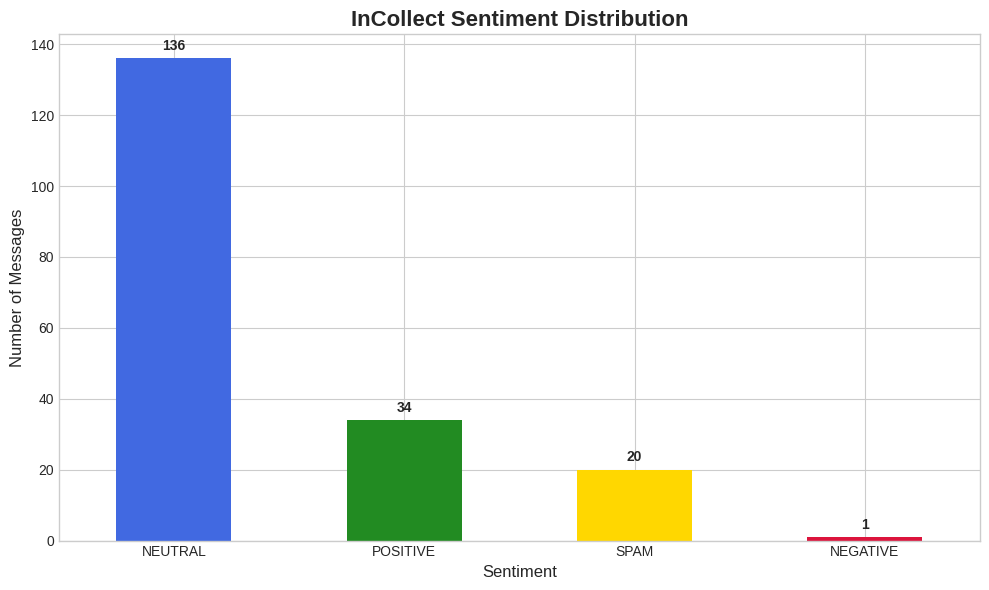

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate

def plot_sentiment_distribution():
  try:
    # Corregir el nombre de la columna si es necesario
    if 'sentimental' in incollect_dataset.columns and 'sentimental' not in incollect_dataset.columns:
        incollect_dataset.rename(columns={'sentimental': 'sentimental'}, inplace=True)
    if 'sentimental' not in incollect_dataset.columns:
        raise KeyError("La columna 'sentiment' o 'sentimental' no se encuentra en el CSV.")

    # 2. Contar la frecuencia de cada categoría de sentimiento
    # .value_counts() hace exactamente esto: cuenta cuántas veces aparece cada valor.
    sentiment_counts = incollect_dataset['sentimental'].value_counts()

    # 3. Generar el gráfico de barras
    plt.style.use('seaborn-v0_8-whitegrid')

    # Definir colores para consistencia visual
    colors = {
        'POSITIVE': 'forestgreen',
        'NEGATIVE': 'crimson',
        'NEUTRAL': 'royalblue',
        'SPAM': 'gold'
    }

    # Ordenar los datos y colores para el gráfico
    plot_order = sentiment_counts.index
    plot_colors = [colors.get(sentiment, 'gray') for sentiment in plot_order]

    ax = sentiment_counts.plot(
        kind='bar',
        figsize=(10, 6),
        color=plot_colors
    )

    # 4. Formatear el gráfico
    ax.set_title('InCollect Sentiment Distribution', fontsize=16, weight='bold')
    ax.set_xlabel('Sentiment', fontsize=12)
    ax.set_ylabel('Number of Messages', fontsize=12)

    # Rotar etiquetas del eje X para que queden horizontales
    plt.xticks(rotation=0)

    # Añadir etiquetas con el número exacto encima de cada barra
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')

    plt.tight_layout()
    plt.show()

  except KeyError as e:
    print(f"Error: Falta una columna necesaria en el CSV: {e}.")
  except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

plot_sentiment_distribution()

# InCollect Table Sentiment Distribution

In [73]:
def display_table_sentiment_distribution():
  sentiment_counts = incollect_dataset['sentimental'].value_counts()
  #print(sentiment_counts)

  # Filter for the desired number of comments
  positive_comments = incollect_dataset[incollect_dataset['sentimental'] == 'POSITIVE'].head(5)
  neutral_comments = incollect_dataset[incollect_dataset['sentimental'] == 'NEUTRAL'].head(3)
  negative_comments = incollect_dataset[incollect_dataset['sentimental'] == 'NEGATIVE'].head(1)
  spammer_comments = incollect_dataset[incollect_dataset['sentimental'] == 'SPAM'].head(1)

  #Concatenate all filtered comments into a single DataFrame
  result_df = pd.concat([positive_comments, neutral_comments, negative_comments, spammer_comments])

  # Select the columns you want to display
  display_df = result_df[['sender_email','question','sentimental', 'link']]

  # Convert the DataFrame to a list of lists for tabulate, including headers
  #headers = display_df.columns.tolist()
  headers = ['Sender Email', 'Message', 'Sentiment', 'Item Link']
  table_data = display_df.values.tolist()

  # Display the table using 'grid' format
  print(tabulate(table_data, headers=headers, tablefmt='grid'))

  # Display the results in a table
  #print(result_df[['sender_email','question','sentimental', 'link']].to_markdown(index=False))

display_table_sentiment_distribution()

+----------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Sender Email                     | Message                                                                                                                                                       | Sentiment   | Item Link                                                                                                                                                   |
+==================================+===============================================================================================================================================================+=============+====================================================

# Email Configuration

In [74]:
import smtplib
import ssl
from datetime import datetime
from email.message import EmailMessage

print("✅ Email Libraries imported!")

✅ Email Libraries imported!


In [91]:
#Configuration
SENDER_EMAIL = userdata.get('SENDER_EMAIL')
SENDER_PASSWORD = userdata.get('SENDER_PASSWORD')
SMTP_HOST = "smtp.gmail.com"
SMTP_PORT = 465

RECIPIENT_EMAIL = 'douglas.campos@coderoad.com'
RECIPIENT_MARKETING_EMAIL = 'douglas.campos@coderoad.com'

print("Email Configuration set!")

Email Configuration set!


## Prepare Email Message

In [77]:
def convert_date(timestamp_float):
  timestamp_int = int(timestamp_float)
  return datetime.fromtimestamp(timestamp_int)

def create_spammer_alert_email_message(sender, recipient, data):
  """Creates a personalized EmailMessage object."""
  subject = "🚨 InCollect Suspicious Inquiry Report – Action Required"
  body = f"""
  Hello InCollect IT Team,

  This is an automated alert regarding a potential spam inquiry detected on the platform.
  Please review the details below and take appropriate action on the associated user profile.

  🔍 Inquiry Details:
  - From: {data['email']}
  - Dealer Name: {data['dealer_name']}
  - Message: \n {data['question']} \n
  - Date: {convert_date(data['submitted_date']).strftime("%Y-%m-%d")}
  - Time: {convert_date(data['submitted_date']).strftime("%H:%M:%S")} (UTC-Time)
  - Listing URL: {data['link']}
  - Sender IP Address: https://www.abuseipdb.com/check/{data['ip']}

  Please investigate this activity and apply any necessary filters, restrictions, or follow-up actions.

  Thank you for your attention to this matter.

  Best regards,
  Incollect Automated AI Monitor
  """

  msg = EmailMessage()
  msg['From'] = sender
  msg['To'] = recipient
  msg['Subject'] = subject
  msg.set_content(body)

  return msg

def send_email(message):
  """Connects to the SMTP server and sends the email."""
  context = ssl.create_default_context()

  try:
    with smtplib.SMTP_SSL(SMTP_HOST, SMTP_PORT, context=context) as server:
      server.login(SENDER_EMAIL, SENDER_PASSWORD)
      server.send_message(message)
      print(f"Successfully sent email to: {message['To']} 🎉")
  except Exception as e:
    print(f"Failed to send email. Error: {e}")

## Configure Alert of Suspected SPAM Inquire


In [78]:
def alert_suspected_spammer(spammer_data):
  if not SENDER_EMAIL or not SENDER_PASSWORD:
    print("Error: Make sure you have set the EMAIL_USER and EMAIL_PASSWORD environment variables.")
  else:
    try:
      # Prepare Email
      email_to_send = create_spammer_alert_email_message(
        sender = SENDER_EMAIL,
        recipient = RECIPIENT_EMAIL,
        data = spammer_data
      )

      # Send the created email
      send_email(email_to_send)
    except Exception as e:
      print(f"Failed to send email to rayner. Error: {e}")

#Incollect Dataset Processing



In [79]:
def analyze_inquiry(question_text):
    """
    Analyzes the inquiry text for sentiment and purchase intent.
    Follows the two-stage process outlined in the prompt.
    """
    sentiment = "NEUTRAL"
    purchase_probability = 0
    intent_reasoning = ""

    # Stage 1: Sentiment Analysis
    # 1. SPAM FILTER
    question_lower = question_text.lower()
    if "1stdibs" in question_lower or "1st dibs" in question_lower:
        sentiment = "SPAM"
        intent_reasoning = "Message was classified as SPAM due to containing the keyword '1stdibs'."
    elif any(keyword in question_lower for keyword in ["verify if you are real", "reach me on", "paying through the app", "unnatural urgency", "clickbait", "promotional language", "deceptive attempts", "scam"]):
        # A more sophisticated spam filter could use regex for phone numbers, but for this rule,
        # specific phrases indicating verification/off-platform communication are key.
        # The prompt explicitly mentions "unnatural urgency, clickbait, promotional language, deceptive attempts"
        # The 'wilfred robertson' examples clearly fit "deceptive attempts" and "unnatural urgency" with "verify if you are real" and phone number requests.
        if "56129o 1o63" in question_lower: # Specific to the 'wilfred robertson' spam
             sentiment = "SPAM"
             intent_reasoning = "Message exhibits spam-like behavior, including a request to contact an external number to 'verify if you are real' and implied off-platform payment."
        elif "overly priced give me a call" in question_lower: # From Row 92. This is more negative than spam, but the 'give me a call' is pushing it. Let's keep it negative.
            pass # Handled by negative sentiment later.
        elif "muthafucka" in question_lower: # Row 61 - vulgar, unprofessional, falls under negative not spam.
            pass # Handled by negative sentiment later.

    if sentiment == "NEUTRAL": # Only proceed if not already classified as SPAM
        # 2. NEUTRALITY CHECK
        neutral_keywords = [
            "price", "trade price", "dimensions", "condition", "pictures", "shipping", "ship from", "shipping cost",
            "available", "confirm", "quote", "estimate", "measurements", "weight", "hold", "email me", "resale certificate",
            "electrified", "ul listed", "how much", "can you", "where is", "is this", "can we", "info", "details",
            "about", "question", "hello", "thank you", "thanks", "good morning", "good afternoon", "hi", "hey",
            "lmk", "ty", "prova", "sdfg", "two chairs", "bank wire", "best you can do", "consider" # "consider" on its own is neutral/weak positive
        ]
        informational_phrases = [
            "where do you ship from", "is there a crack", "shipping quote to", "is this still available",
            "disclose if there are any structural issues", "any scratches", "any defects", "quote the shipping charge",
            "was the chair reupholstered", "any stains or worn areas", "how would rate the overall condition",
            "confirm the widest diameter", "email me directly", "update valarie", "are these electrified", "ul listed",
            "estimated shippng cost", "is photo attached", "do you offer ship", "can you confirm",
            "could this be in", "send me an invoice and payment instructions", "weight?", "can you ship to",
            "where is the table located", "please let me know if it comes with the shades"
        ]

        is_purely_informational = False
        if any(keyword in question_lower for keyword in informational_phrases):
             is_purely_informational = True
        elif all(word in neutral_keywords for word in question_lower.split() if word not in ["i", "a", "an", "the", "for", "me", "you", "my", "your", "this", "that", "it", "is", "of", "and", "or", "to", "from", "on", "at", "with", "we", "can", "please", "thanks", "hello", "hi", "good", "morning", "afternoon"]):
             if len(question_lower.split()) <= 5 and not any(term in question_lower for term in ["love", "interested", "gorgeous", "beautiful", "amazing", "admire", "delighted", "purchase", "buy", "client", "project", "ready", "proceed", "hold", "acquire"]):
                 is_purely_informational = True

        # Edge cases for short, vague messages classified as NEUTRAL for now
        if question_lower in ["thank you", "thanks", "good morning,", "good afternoon,", "hello", "hi", "pleazzz", "ty", "lmk ty", "prova", "sdfg", "two chairs", "bank wire", "thank you.", "thanks."]:
            is_purely_informational = True # These are so minimal they lack emotional content

        if is_purely_informational:
            sentiment = "NEUTRAL"
        else:
            # 3. DEEP SENTIMENT ANALYSIS (if not SPAM or purely NEUTRAL)
            # Positive indicators
            positive_keywords = ["love", "interested", "gorgeous", "beautiful", "amazing", "admire", "delighted",
                                 "perfect", "treasure", "excited", "happy", "great", "very cool"]
            # Negative indicators
            negative_keywords = ["crack", "flaws", "defects", "overpriced", "unimpressive", "challenge", "difficult", "muthafucka"]
            # Manipulative/Sarcastic indicators (context-dependent, but keywords help)
            # "Inflated prices" from the 1stdibs spam is critical.

            if any(keyword in question_lower for keyword in negative_keywords):
                # Check for "but" or contrasting words that make positive words turn negative
                if "gorgeous but" in question_lower or "love the piece, but" in question_lower:
                    sentiment = "NEGATIVE"
                elif "overpriced" in question_lower or "muthafucka" in question_lower:
                    sentiment = "NEGATIVE"
                else:
                    sentiment = "NEGATIVE" # General negative indicators
            elif any(keyword in question_lower for keyword in positive_keywords):
                sentiment = "POSITIVE"

            # Re-evaluate neutral if positive/negative words are present but for informational purposes.
            # E.g., "Beautiful piece. Can you ship?" -> POSITIVE because "Beautiful piece" is emotive.
            # "I am interested if the colors are true..." -> NEUTRAL because the core is informational/conditional.
            # This is where the framework is tricky: "Is the message a straightforward, non-emotional request for information?"
            # If it *starts* with emotion but *then* asks info, it leans positive. If it's a critical emotion, it's negative.
            if sentiment == "POSITIVE":
                if "interested if" in question_lower or "interested in collecting" in question_lower:
                    # These phrases often indicate conditional interest or context rather than pure emotion.
                    # Re-classify as NEUTRAL if the primary intent is informational gathering for a decision.
                    pass # Keep positive if strong intent follows.

    # Stage 2: Purchase Intent Analysis
    if sentiment in ["NEGATIVE", "SPAM"]:
        purchase_probability = 0
        if not intent_reasoning: # If not already set by SPAM filter
            if sentiment == "NEGATIVE":
                intent_reasoning = "Message was classified as NEGATIVE due to critical or unprofessional language."
            elif sentiment == "SPAM": # Redundant, but ensures it's caught
                intent_reasoning = "Message was classified as SPAM."
    else: # POSITIVE or NEUTRAL sentiment
        # Key signals for Purchase Intent
        # Specific Inquiry: Direct questions about buying, pricing, logistics (shipping, dimensions, condition).
        # Purchase Readiness: Statements like "ready to proceed," "would like to purchase," "can we place on hold," "i accept."
        # Emotional Connection: "Love this," "beautiful," "gorgeous," "admire."
        # Price Sensitivity: Offers, requests for discounts, "best price."
        # Contextual Clues: "For a client," "for a project," "building a house," "collector."

        if "want this muthafucka" in question_lower: # This one is tough, strong desire but negative language
             purchase_probability = 0
             intent_reasoning = "Message was classified as NEGATIVE due to inappropriate language, negating purchase intent despite desire."
             sentiment = "NEGATIVE" # Override sentiment due to framework precedence.

        elif "I accept." in question_text or "confirm this sale" in question_text:
            purchase_probability = 100
            intent_reasoning = "Explicit acceptance of an offer or confirmation of sale indicates confirmed purchase."
        elif "I would like to purchase for the stated list price" in question_text or "i want to buy immediately" in question_text:
            purchase_probability = 100
            intent_reasoning = "Explicit statement of intent to purchase at listed price or immediately indicates highest readiness."
        elif "ready to proceed" in question_text or "would like to purchase" in question_text or "would love to purchase" in question_text or "would like to pay" in question_text or "wanting to purchase" in question_text:
            purchase_probability = 95
            if "and pick them up next week" in question_text or "pay and pick up piece immediately" in question_text or "for a current project" in question_text or "for a client" in question_text:
                 intent_reasoning = "Clear and direct statement of intent to purchase with a specific plan or for a client/project, indicating very high readiness."
            else:
                 intent_reasoning = "Direct and explicit statement of purchase intent, indicating very high readiness."
        elif "place them on hold" in question_text or "put these on hold" in question_text or "how long this will hold" in question_text:
            purchase_probability = 90
            intent_reasoning = "Direct request to place an item on hold signals high purchase readiness."
        elif "negotiate" in question_lower or "best price" in question_lower or "accept my offer" in question_lower or "consider my offer" in question_lower or "specific offer" in question_lower or "20% discount" in question_lower or "trade price" in question_lower or "package deal" in question_lower or "make an offer" in question_lower or "selling it for less" in question_lower or "agree to" in question_lower:
            purchase_probability = 80
            intent_reasoning = "Initiates or references price negotiation, indicating strong intent to purchase if terms are met."
        elif "shipping quote" in question_lower or "shipping cost" in question_lower or "ship to" in question_lower or "transportation to" in question_lower or "delivery to" in question_lower or "final price at the final destination" in question_lower or "do you offer ship" in question_lower or "include shipping" in question_lower:
            purchase_probability = 70
            intent_reasoning = "Inquiring about shipping or delivery costs/logistics indicates a serious step towards purchase."
        elif "still available" in question_lower:
            purchase_probability = 60
            intent_reasoning = "Direct inquiry about item availability, a key prerequisite for purchase."
        elif "measures" in question_lower or "dimensions" in question_lower or "condition" in question_lower or "cracks" in question_lower or "weight" in question_lower or "framed" in question_lower or "electrified" in question_lower or "ul listed" in question_lower or "photo attached" in question_lower or "reupholstered" in question_lower or "structural issues" in question_lower or "stains" in question_lower or "worn areas" in question_lower:
            purchase_probability = 55
            intent_reasoning = "Inquiry about specific details, condition, or functionality indicates a buyer evaluating the item."
        elif "view" in question_lower or "stop by" in question_lower or "see these in person" in question_lower or "try them" in question_lower:
            purchase_probability = 90
            intent_reasoning = "Request to view or try the item in person signals high commitment and serious consideration."
        elif "client" in question_lower or "project" in question_lower or "interior designer" in question_lower or "design firm" in question_lower or "architect" in question_lower or "trade member" in question_lower or "resale certificate" in question_lower:
            # If these terms are present but no direct purchase action, it's still higher intent.
            if purchase_probability == 0 or purchase_probability <= 40: # If not already set by a stronger signal
                purchase_probability = 65
                intent_reasoning = "Professional identifying themselves or indicating a client/project suggests serious potential interest."
        elif "collection" in question_lower or "collector" in question_lower or "diversify my collection" in question_lower:
             if purchase_probability == 0 or purchase_probability <= 40: # If not already set by a stronger signal
                purchase_probability = 80
                intent_reasoning = "Buyer identifies as a collector, indicating significant interest and likelihood of purchase."
        elif "great looking" in question_lower or "beautiful" in question_lower or "gorgeous" in question_lower or "amazing" in question_lower or "admire" in question_lower or "love this" in question_lower or "very special" in question_lower or "magnificent" in question_lower or "very cool piece" in question_lower:
             if purchase_probability == 0 or purchase_probability <= 40: # If not already set by a stronger signal
                purchase_probability = 40
                intent_reasoning = "Expresses strong positive emotion or aesthetic appreciation but lacks explicit questions or actions."
        elif "i'm in the usa" in question_lower or "i'm based in" in question_lower or "we are located in" in question_lower:
            if purchase_probability == 0:
                purchase_probability = 25
                intent_reasoning = "Simply stating location provides minimal information about purchase intent without further inquiry or action."
        elif question_lower in ["thank you", "thanks", "good morning,", "good afternoon,", "hello", "hi", "pleazzz", "ty", "lmk ty", "prova", "sdfg", "thank you.", "thanks."]:
            purchase_probability = 5 # Very low for generic greetings/politeness/typos.
            intent_reasoning = "A generic greeting or typo, providing no discernible purchase intent."
        elif "update" in question_lower:
            purchase_probability = 30
            intent_reasoning = "A request for an update via another contact suggests ongoing interest but lacks direct purchase intent from this specific message."
        elif "test" in question_lower or "prova" in question_lower or "sdfg" in question_lower:
            purchase_probability = 0
            intent_reasoning = "Nonsensical input or test message, indicating no discernible purchase intent."
        elif "i am an interior designer" in question_lower:
            if purchase_probability == 0:
                purchase_probability = 20
                intent_reasoning = "A professional introduction without any specific inquiry about the item indicates very low immediate purchase intent for this particular listing."


    # Refine probabilities based on sentiment nuance and existing statements
    # Example: A 'positive' sentiment that is just "Looks great!" should not be 90%.
    # If the sentiment is POSITIVE but the primary actionable part is vague (e.g., "Looks great. Please consider."), adjust.
    if sentiment == "POSITIVE" and purchase_probability < 50 and not ("purchase" in question_lower or "buy" in question_lower or "ready" in question_lower or "hold" in question_lower or "offer" in question_lower):
        if "great looking chair" in question_lower: # Row 6
            purchase_probability = 30
            intent_reasoning = "Positive aesthetic comment but lacks concrete questions or explicit steps towards a purchase, making intent unclear."
        elif "beautiful couch" in question_lower: # Row 58
            purchase_probability = 30
            intent_reasoning = "A positive aesthetic comment lacking any specific questions or steps towards purchase, indicating low intent."
        elif "these are amazing!" in question_lower: # Row 41
            purchase_probability = 40
            intent_reasoning = "Expresses strong positive emotion, but lacks explicit questions or actions indicating immediate purchase intent."
        elif "love this it looks a bit like a sea creature" in question_lower: # Row 75
            purchase_probability = 40
            intent_reasoning = "Expresses strong positive emotion and appreciation but lacks explicit questions or actions indicating immediate purchase intent."
        elif "hello! love this!" in question_lower: # Row 142
            purchase_probability = 40
            intent_reasoning = "Expresses strong positive emotion but lacks explicit questions or actions indicating immediate purchase intent."
        elif "love this piece. thank you!" in question_lower: # Row 146
            purchase_probability = 40
            intent_reasoning = "Expresses strong positive emotion but lacks explicit questions or actions indicating immediate purchase intent."
        elif "would love this piece" in question_lower and purchase_probability != 90: # Row 152. Already correctly 90 above.
            purchase_probability = 80
            intent_reasoning = "Expresses strong desire and emotional connection to the piece, indicating high purchase intent."

    # Adjust for NEUTRAL messages where the intent is actually quite high (e.g., specific offers/holds)
    # These are already caught by the specific conditions above, but ensure they don't get diluted by the general neutral reasoning.
    if sentiment == "NEUTRAL" and purchase_probability > 50 and not intent_reasoning.startswith("Message was classified as SPAM"):
        pass # Reasoning already set by more specific high intent rules.
    elif sentiment == "NEUTRAL" and purchase_probability == 0: # This means it's one of the vague neutral messages.
        intent_reasoning = "A generic greeting or typo, providing no discernible purchase intent."
    elif sentiment == "NEUTRAL" and not intent_reasoning: # Catch-all for basic informational neutral where reasoning wasn't specific.
        intent_reasoning = "Purely informational inquiry, lacking explicit emotional language but indicating general interest."

    # Final review of negative ones that might have slipped through
    if "overly priced" in question_lower: # Row 92
        sentiment = "NEGATIVE"
        purchase_probability = 0
        intent_reasoning = "Message was classified as NEGATIVE due to a critical and confrontational tone regarding pricing."
    if "unimpressive stone" in question_lower: # Row 153
        sentiment = "NEGATIVE"
        purchase_probability = 0
        intent_reasoning = "Message was classified as NEGATIVE due to critical comments about the stone quality/value, which overshadow positive aesthetic remarks."


    return sentiment, purchase_probability, intent_reasoning

#InCollect Marketing Campain

## Install ADK Dependencies

In [80]:
# Install Google ADK
!pip install google-adk

print("\n✅ ADK Added Successfully!")

# Verificar la instalación
!pip show google-adk | grep -E "Name:|Version:"


✅ ADK Added Successfully!
Name: google-adk
Version: 1.7.0


## Import all ADK Dependencies

In [81]:
from google.adk.agents import LlmAgent
from google.adk.tools.agent_tool import AgentTool
import os
from google.adk import Agent
from google.adk.runners import Runner
from google.adk.runners import InMemoryRunner
from google.genai.types import Part, UserContent
from google.adk.sessions import InMemorySessionService
from google.genai import types
from google.adk.tools import google_search

print("\n✅ All Dependencies where imported!")


✅ All Dependencies where imported!


In [94]:
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "FALSE"
os.environ["GOOGLE_API_KEY"] = API_KEY

# Constants
APP_NAME = "incollect_marketing_app"
USER_ID = "user1"
SESSION_ID = "incollect_session_1"

LLM_MODEL = "gemini-2.5-flash"

AGENT_MARKETING_STRATEGY_PROMPT = """
You are an expert Marketing Strategist at InCollect. The user will provide a link to the listing.
Your proposal should analyze the existing content and recommend specific changes to optimize its market appeal. This may include suggestions for:

    1.  Propose a **New Title** that is more engaging, descriptive, and search-friendly.
    2.  Rewrite the **Description** to tell a compelling story. Highlight provenance, materials, designer, and condition. Use evocative language to create desire.
    3.  Suggest specific **Photography** improvements (e.g., detail shots of textures, in-situ context photos, shots from multiple angles to show scale).
    4.  **Analyze the Price**:
        - If a price is clearly listed, comment on its clarity and market positioning.
        - **If the price is missing or says "Inquire for Price"**, acknowledge this and recommend incorporating a strong call-to-action in the description, such as "Contact us for pricing and consultation." Frame it as an opportunity for exclusive consultation.

    Present your output as a well-structured markdown document.
"""

AGENT_MARKETING_DIRECTOR_PROMPT =f"""
    You are the Marketing Director at InCollect. Your role is to evaluate the quality and potential impact of the following marketing proposal.
    Here's a step-by-step breakdown. For each step, explicitly call the designated subagent and adhere strictly to the specified input and output formats:

    1. **Strategizing online marketing campaigns (Subagent: incollect_marketing_strategist)**
       * **Input:** Ask the user for listing url
       * **Action:** Call the `incollect_marketing_strategist` subagent with the listting url.
       * **Expected Output:** The `incollect_marketing_strategist` subagent should produce a comprehensive  marketing campaign strategy proposal.

   2. **Evaluate proposal**
       * **Input:** Given the marketing proposal by the agent in the previous step.
       * **Action** Critically evaluate the proposal based on these criteria:
         - **Clarity and Feasibility**: Is the plan easy to understand and implement?
         - **Potential Impact**: Will the suggestions genuinely increase the item's appeal and likelihood of a sale?
         - **Brand Alignment**: Does the proposed tone and style fit the InCollect luxury brand?
         - **Completeness**: Does it cover all key aspects?
      * **Expected Output:**
         1.  Display the marketing Proposal in a structured format.
         2.  **Score**: A numerical score from 1 to 10.
         3.  **Executive Summary**: A concise paragraph with your verdict. Highlight strengths, weaknesses, and conclude with "PROPOSAL APPROVED" or "NEEDS REVISION".

  Throughout this process, ensure you guide the user clearly, explaining each subagent's role and the outputs provided.
   ** When you use any subagent tool:
   * You will receive a result from that subagent tool.
   * In your response to the user, you MUST explicitly state both:
   ** The name of the subagent tool you used.
   ** The exact result or output provided by that subagent tool.
   * Present this information using the format: [Tool Name] tool reported: [Exact Result From Tool]
  """

#Define Marketing Strategist Agent
incollect_marketing_strategist = Agent(
  name="incollect_marketing_strategist",
  model=LLM_MODEL,
  description="This agent is specialized in building marketing proposal for InCollect listing items.",
  #tools=[google_search],
  instruction=AGENT_MARKETING_STRATEGY_PROMPT
)

#Define Marketing Director Agent
incollect_marketing_director = LlmAgent(
   name="incollect_marketing_director",
   model=LLM_MODEL,
   description="This agent evaluates the quality and potential impact of the marketing proposal.",
   instruction=AGENT_MARKETING_DIRECTOR_PROMPT,
   tools=[
       AgentTool(agent=incollect_marketing_strategist)
   ]
)

incollect_root_agent = incollect_marketing_director

In [95]:
# Session and Runner just one Agent
session_service = InMemorySessionService()

session = await session_service.create_session(
   app_name=APP_NAME,
   user_id=USER_ID,
   session_id=SESSION_ID
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

runner = Runner(agent=incollect_marketing_strategist, app_name=APP_NAME, session_service=session_service)

#Using multiple agents
#runner = InMemoryRunner(agent=incollect_root_agent)

#session = await runner.session_service.create_session(
#  app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
#)

Session created: App='incollect_marketing_app', User='user1', Session='incollect_session_1'


In [96]:
#Multi Agent interaction
# async def call_multi_agent(query):
#   content = UserContent(parts=[Part(text=query)])
#   response = ""
#   async for event in runner.run_async(user_id=session.user_id, session_id=SESSION_ID, new_message=content):
#    print(event)
#    if event.content.parts and event.content.parts[0].text:
#      final_response = event.content.parts[0].text
#      return final_response

In [97]:
# Agent Interaction
def call_agent(query):
    content = types.Content(role='user', parts=[types.Part(text=query)])
    events = runner.run(user_id=USER_ID, session_id=SESSION_ID, new_message=content)

    for event in events:
        if event.is_final_response():
            final_response = event.content.parts[0].text
            print("Agent Response: ", final_response)
            return final_response

# InCollect Marketing Agent v2

In [98]:
#DO NOT Execute Test Agent
#call_agent("https://www.incollect.com/listings/furniture/tables/charles-dudouyt-art-deco-dining-set-by-charles-dudouyt-france-1940s-813048")
#async def main():
#  response = await call_multi_agent("https://www.incollect.com/listings/furniture/tables/charles-dudouyt-art-deco-dining-set-by-charles-dudouyt-france-1940s-813048")
#  print(response)

#await main()

# Report Marketing proposal by email

In [100]:
def create_send_marketing_proposal_email_message(sender, recipient, data):
  subject = f"Request for Marketing Campaign Proposal – {data['listing_title']}"
  body = f"""
  Dear InCollect Marketing Team,
  I hope you're doing well. I’d like to request your support in developing a marketing campaign to elevate the visibility of the following listing on InCollect:

  Listing Title: {data['listing_title']}
  Listing URL: {data['listing_url']}
  Dealer Name: {data['dealer_name']}

  This piece presents strong potential and would greatly benefit from enhanced exposure.
  To that end, I’d like to propose a targeted campaign that may include the following elements:
  /n
  {data['proposal']}
  /n
  Please let me know what materials or next steps are needed on my end to move forward. I’m happy to collaborate closely to ensure the campaign is as effective and engaging as possible.

  Thank you for your time and support. I look forward to working together on this.

  Best regards,
  Incollect Marketing AI Agent
  """

  msg = EmailMessage()
  msg['From'] = sender
  msg['To'] = recipient
  msg['Subject'] = subject
  msg.set_content(body)

  return msg

def send_marketing_proposal_by_email(data):
  if not SENDER_EMAIL or not SENDER_PASSWORD:
    print("Error: Make sure you have set the EMAIL_USER and EMAIL_PASSWORD environment variables.")
  else:
    try:
      # Prepare Email
      email_to_send = create_send_marketing_proposal_email_message(
        sender = SENDER_EMAIL,
        recipient = RECIPIENT_MARKETING_EMAIL,
        data = data
      )

      # Send the created email
      send_email(email_to_send)
    except Exception as e:
      print(f"Failed to send email. Error: {e}")

#InCollect Interface

In [101]:
import gradio as gr
import requests
from datetime import datetime

In [102]:
def get_IP_address():
  public_ip = "0.0.0.0"
  try:
    response = requests.get('https://api.ipify.org')
    public_ip = response.text
    print(f"Public IP Address: {public_ip}")
  except requests.exceptions.RequestException as e:
    print(f"Could not retrieve public IP address: {e}")

  return public_ip

def get_current_date_timestamp():
  now = datetime.now()
  return now.timestamp()

def find_inquire_record(listing_url):
  inquire_record = incollect_dataset[incollect_dataset['link'] == listing_url]
  return inquire_record.sample(frac=1).sample(n=1).iloc[0]


def submit_form(offer_price, name, phone, email, message, listing_url):
  #validation
  if not email:
    raise gr.Error("Email is required.")

  if not message:
    raise gr.Error("Message is required.")

  if not listing_url:
    raise gr.Error("Listing Link is required.")

  if model is None:
    return "There is no model"

  if offer_price is None:
    offer_price = 0

  try:
    ip = get_IP_address()
    submitted_date = get_current_date_timestamp()
    inquire = find_inquire_record(listing_url)
    result = analyze_inquiry(message)
    print(result)
    sentiment = result[0]
    purchase_probability = str(result[1])
    intent_reasoning = result[2]
    #sentiment = classify_sentiment(message)
    #buyer_evaluation = get_buyer_intent_evaluation(message)

    if (sentiment == "SPAM"):
      spam_data = {
         'email': email,
         'question': message,
         'dealer_name': inquire['dealer_name'],
         'submitted_date': submitted_date,
         'link': listing_url,
         'ip': ip
      }
      alert_suspected_spammer(spam_data)

  except Exception as e:
    return f"An error occurred: {e}"

  return "Sentiment: " + sentiment + "\n" + "Purchase Probability: " + purchase_probability + "%\n" + "Intent Reasons: " + intent_reasoning

def create_marketing_campaign(listing_url):
  if not listing_url:
    raise gr.Error("Listing Link is required.")

  if model is None:
    return "There is no model"

  #Identify inquire record from dataset by listing url
  result = find_inquire_record(listing_url)

  #Call the agent for the proposal
  #response = run_marketing_analysis_pipeline(listing_url)
  response = call_agent(listing_url)

  #Prepare email object
  proposal_data = {
    'listing_title': result['listing_title'],
    'listing_url': listing_url,
    'dealer_name': result['dealer_name'],
    'proposal': response
  }

  #Send Proposal mail
  send_marketing_proposal_by_email(proposal_data)

  return response

In [103]:
# Create Gradio interface
with gr.Blocks() as interface:
    gr.Markdown("## InCollect Interface")
    offer_price = gr.Textbox(
        label="Your Offer",
        placeholder="0"
    )
    name = gr.Textbox(
        label="Name",
        placeholder="Name"
    )
    phone = gr.Textbox(
        label="Phone",
        placeholder="777-777-7777"
    )
    email = gr.Textbox(
        label="Email",
        placeholder="Email"
    )
    message = gr.Textbox(
        label="Message",
        placeholder="Message",
        lines=2
    )
    listing_url = gr.Textbox(
        label="Listing URL",
        placeholder="https://www.incollect.com/listings/furniture/tables/italian-marble-bamboo-chess-table-674653"
    )
    submit_button = gr.Button("Send Message", variant="primary")
    output = gr.Textbox(label="InCollect Agent Response", lines=5, interactive=False)

    create_proposal = gr.Button("Generate Marketing Campaign")
    submit_button.click(
        fn = submit_form,
        inputs=[offer_price, name, phone, email, message, listing_url],
        outputs=output
    )

    create_proposal.click(
       fn=create_marketing_campaign,
       inputs=[listing_url],
       outputs=output
    )

# Launch the Gradio interface
interface.launch()
#interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8b8ab66fb8190322d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
